# BTC Transaction Fee Forecasting -- Data Explorer Notebook

This Lambda function hits the following **5 endpoints** from the [mempool.space API](https://mempool.space/docs/api):

- **`GET /api/v1/fees/mempool-blocks`**  
  → Used to fetch projected mempool blocks and their fee ranges (though `feeRange` is discarded).

- **`GET /api/v1/fees/recommended`**  
  → Returns recommended fee rates for fastest, half-hour, hour, and minimum confirmation targets.

- **`GET /api/mempool`**  
  → Fetches aggregate mempool statistics (e.g. total vsize, count).

- **`GET /api/v1/difficulty-adjustment`**  
  → Gets data related to the current difficulty epoch (e.g. progress %, estimated retarget).

- **`GET /api/v1/prices`**  
  → Provides current BTC price data (probably in multiple currencies).

## Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Ingestion

In [3]:
df = pd.read_parquet('../data/raw/extracted_s3.parquet')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11902 entries, 0 to 11901
Data columns (total 83 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   timestamp                                 11902 non-null  int64  
 1   mempool_blocks_blockSize                  11901 non-null  float64
 2   mempool_blocks_blockVSize                 11901 non-null  float64
 3   mempool_blocks_nTx                        11901 non-null  float64
 4   mempool_blocks_totalFees                  11901 non-null  float64
 5   mempool_blocks_medianFee                  11901 non-null  float64
 6   recommended_fee_fastestFee                11902 non-null  float64
 7   recommended_fee_halfHourFee               11902 non-null  float64
 8   recommended_fee_hourFee                   11902 non-null  float64
 9   recommended_fee_economyFee                11902 non-null  float64
 10  recommended_fee_minimumFee        

## Cleaning

### Remove histogram cols with only 0 values

In [5]:
# Filter columns that start with "mempool_fee_histogram_bin_"
hist_cols = [col for col in df.columns if col.startswith("mempool_fee_histogram_bin_")]

# Identify columns where all values are 0.0
zero_hist_cols = [col for col in hist_cols if (df[col] == 0.0).all()]

print("Histogram columns with only 0 float values:")
print(zero_hist_cols)

Histogram columns with only 0 float values:
['mempool_fee_histogram_bin_300_350', 'mempool_fee_histogram_bin_350_400', 'mempool_fee_histogram_bin_400_450', 'mempool_fee_histogram_bin_450_500', 'mempool_fee_histogram_bin_500_550', 'mempool_fee_histogram_bin_550_600', 'mempool_fee_histogram_bin_600_650', 'mempool_fee_histogram_bin_650_700', 'mempool_fee_histogram_bin_700_750', 'mempool_fee_histogram_bin_750_800', 'mempool_fee_histogram_bin_800_850', 'mempool_fee_histogram_bin_850_900', 'mempool_fee_histogram_bin_900_950', 'mempool_fee_histogram_bin_950_1000', 'mempool_fee_histogram_bin_1000_plus']


In [6]:
cols_to_drop = [
    'mempool_fee_histogram_bin_300_350', 'mempool_fee_histogram_bin_350_400',
    'mempool_fee_histogram_bin_400_450', 'mempool_fee_histogram_bin_450_500',
    'mempool_fee_histogram_bin_500_550', 'mempool_fee_histogram_bin_550_600',
    'mempool_fee_histogram_bin_600_650', 'mempool_fee_histogram_bin_650_700',
    'mempool_fee_histogram_bin_700_750', 'mempool_fee_histogram_bin_750_800',
    'mempool_fee_histogram_bin_800_850', 'mempool_fee_histogram_bin_850_900',
    'mempool_fee_histogram_bin_900_950', 'mempool_fee_histogram_bin_950_1000',
    'mempool_fee_histogram_bin_1000_plus'
]

df.drop(columns=cols_to_drop, inplace=True)

### Set timestamp as index

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.sort_values('timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)
df.set_index('timestamp', inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11902 entries, 2025-03-05 02:12:13 to 2025-04-15 09:54:42
Data columns (total 67 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   mempool_blocks_blockSize                  11901 non-null  float64
 1   mempool_blocks_blockVSize                 11901 non-null  float64
 2   mempool_blocks_nTx                        11901 non-null  float64
 3   mempool_blocks_totalFees                  11901 non-null  float64
 4   mempool_blocks_medianFee                  11901 non-null  float64
 5   recommended_fee_fastestFee                11902 non-null  float64
 6   recommended_fee_halfHourFee               11902 non-null  float64
 7   recommended_fee_hourFee                   11902 non-null  float64
 8   recommended_fee_economyFee                11902 non-null  float64
 9   recommended_fee_minimumFee                11902 non-null  float64
 10 

In [9]:
df

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:12:13,2210077.0,997916.50,556.0,1615739.0,1.300082,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:14:41,2131827.0,997874.25,1030.0,2077770.0,1.300139,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:19:42,1986259.0,997882.00,1915.0,2663152.0,2.000000,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:24:41,1814202.0,997958.25,2710.0,3423846.0,2.413300,3.0,3.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:29:42,1604116.0,997937.50,3256.0,4136741.0,3.008581,4.0,3.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-15 09:34:42,1731329.0,997991.75,3810.0,4524017.0,2.149812,3.0,3.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-04-15 09:39:41,1593473.0,997958.75,3874.0,3061643.0,2.000000,2.0,2.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-04-15 09:44:41,1732510.0,997988.50,4511.0,4356829.0,1.554327,2.0,2.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df.to_csv('../data/processed/clean_df.csv', index=False)

## Exploratory Data Analysis

In [9]:
# Summary statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
       mempool_blocks_blockSize  mempool_blocks_blockVSize  \
count              1.190100e+04               11901.000000   
mean               1.559835e+06              934792.751639   
std                3.834879e+05              193006.781627   
min                7.501000e+03                4367.250000   
25%                1.486038e+06              997909.250000   
50%                1.621340e+06              997952.250000   
75%                1.740367e+06              997982.000000   
max                3.889621e+06              997999.750000   

       mempool_blocks_nTx  mempool_blocks_totalFees  mempool_blocks_medianFee  \
count        11901.000000              1.190100e+04              11901.000000   
mean          2661.582724              3.914089e+06                  2.630856   
std           1170.740546              3.618740e+06                  5.128006   
min             15.000000              1.565800e+04                  0.000000   
25%           1

In [10]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
mempool_blocks_blockSize             1
mempool_blocks_blockVSize            1
mempool_blocks_nTx                   1
mempool_blocks_totalFees             1
mempool_blocks_medianFee             1
                                    ..
mempool_fee_histogram_bin_95_100     0
mempool_fee_histogram_bin_100_150    0
mempool_fee_histogram_bin_150_200    0
mempool_fee_histogram_bin_200_250    0
mempool_fee_histogram_bin_250_300    0
Length: 67, dtype: int64


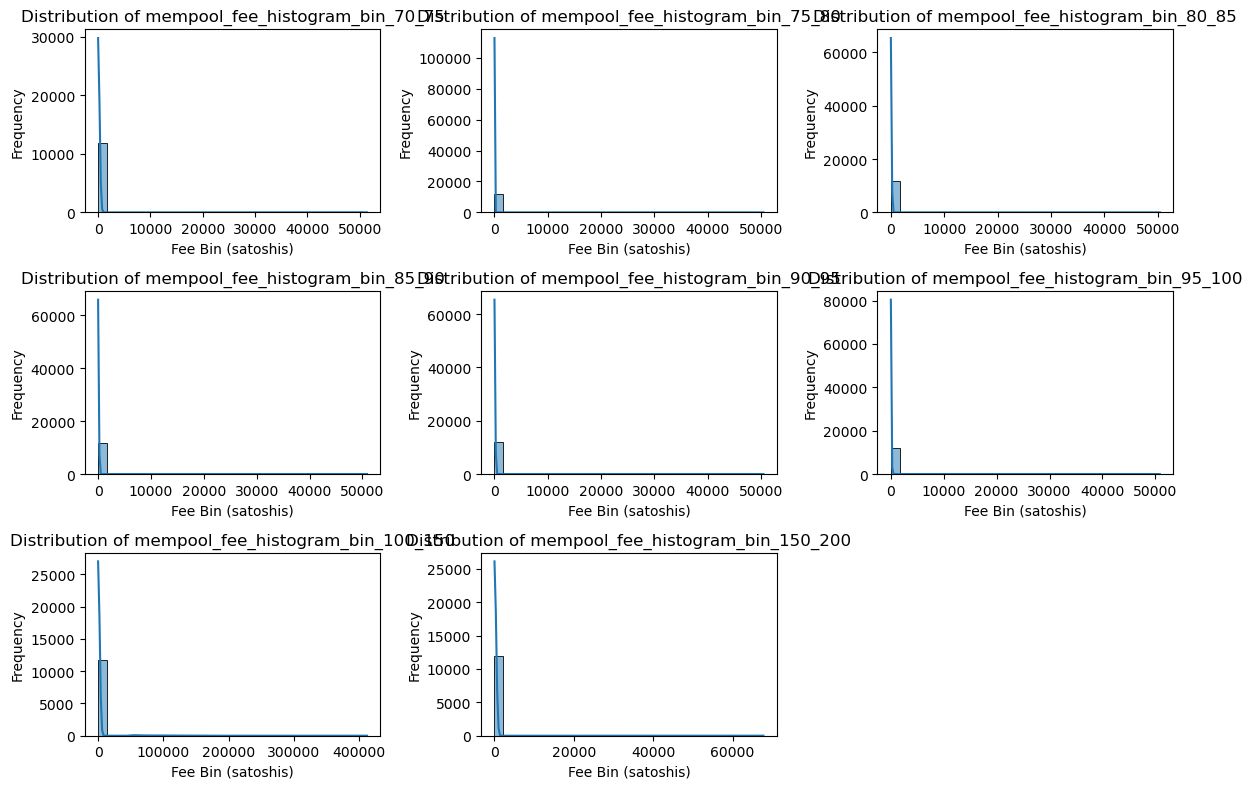

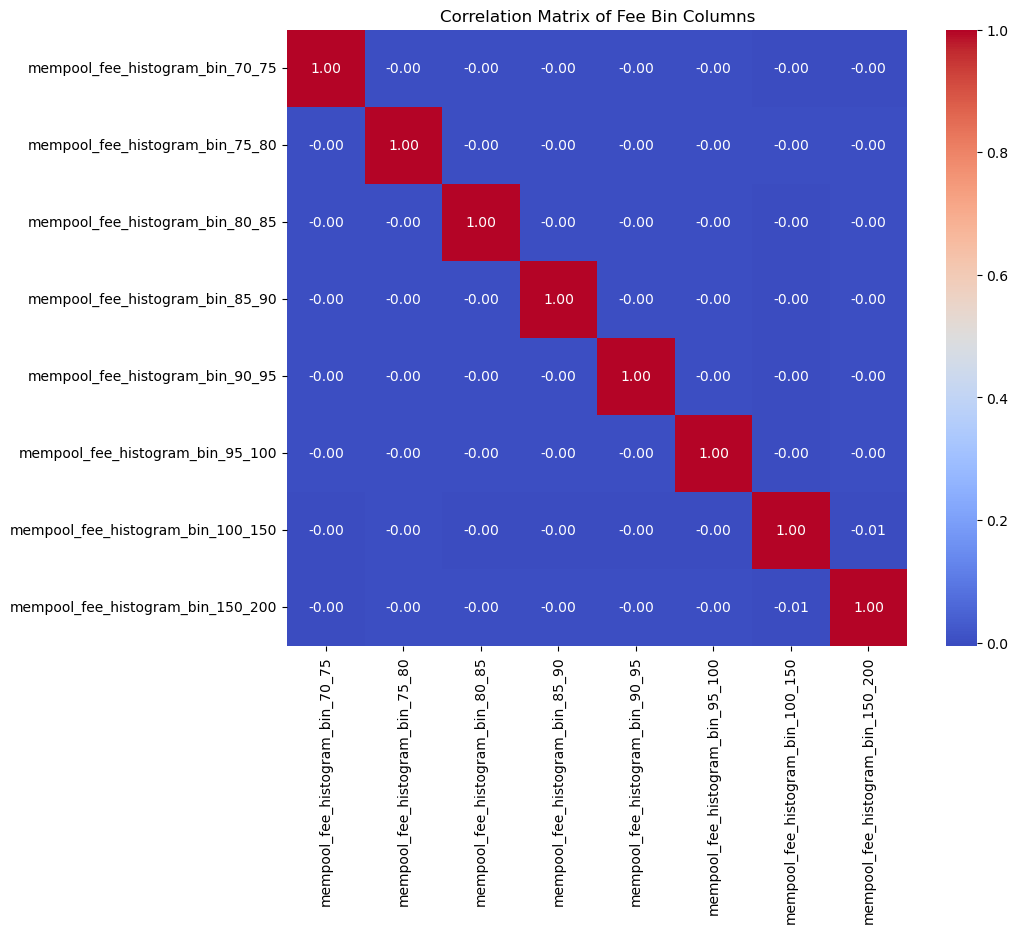

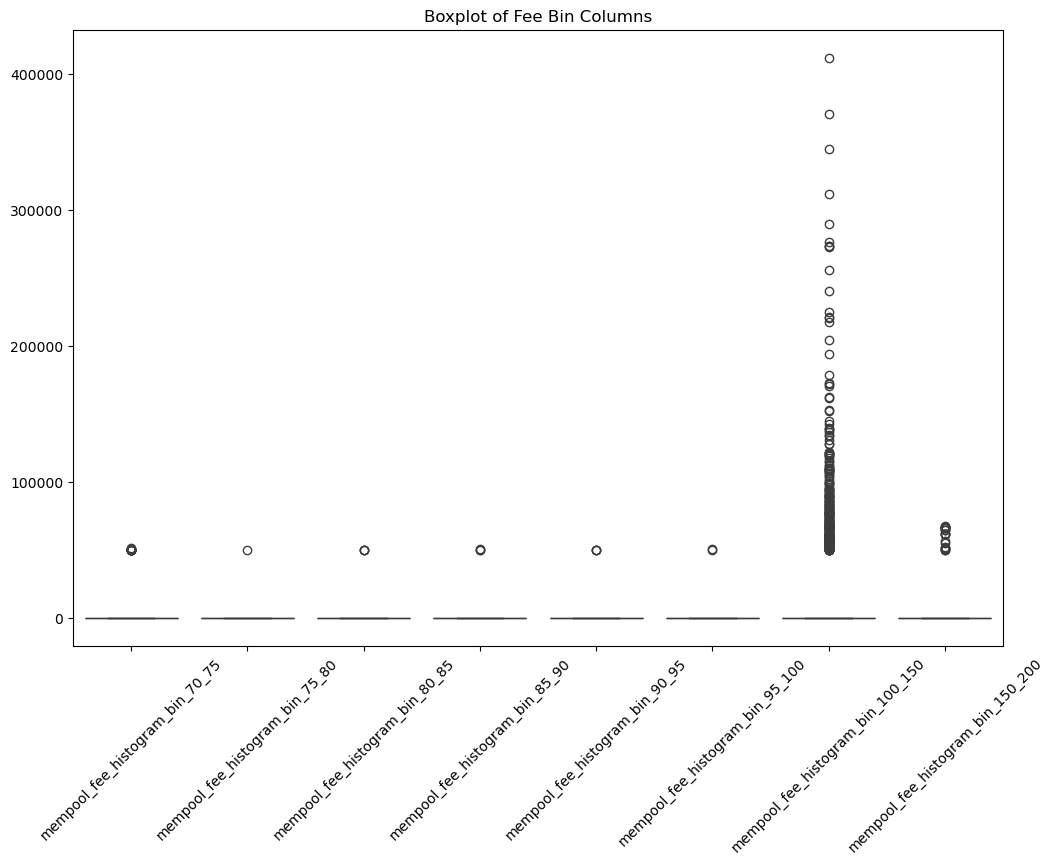

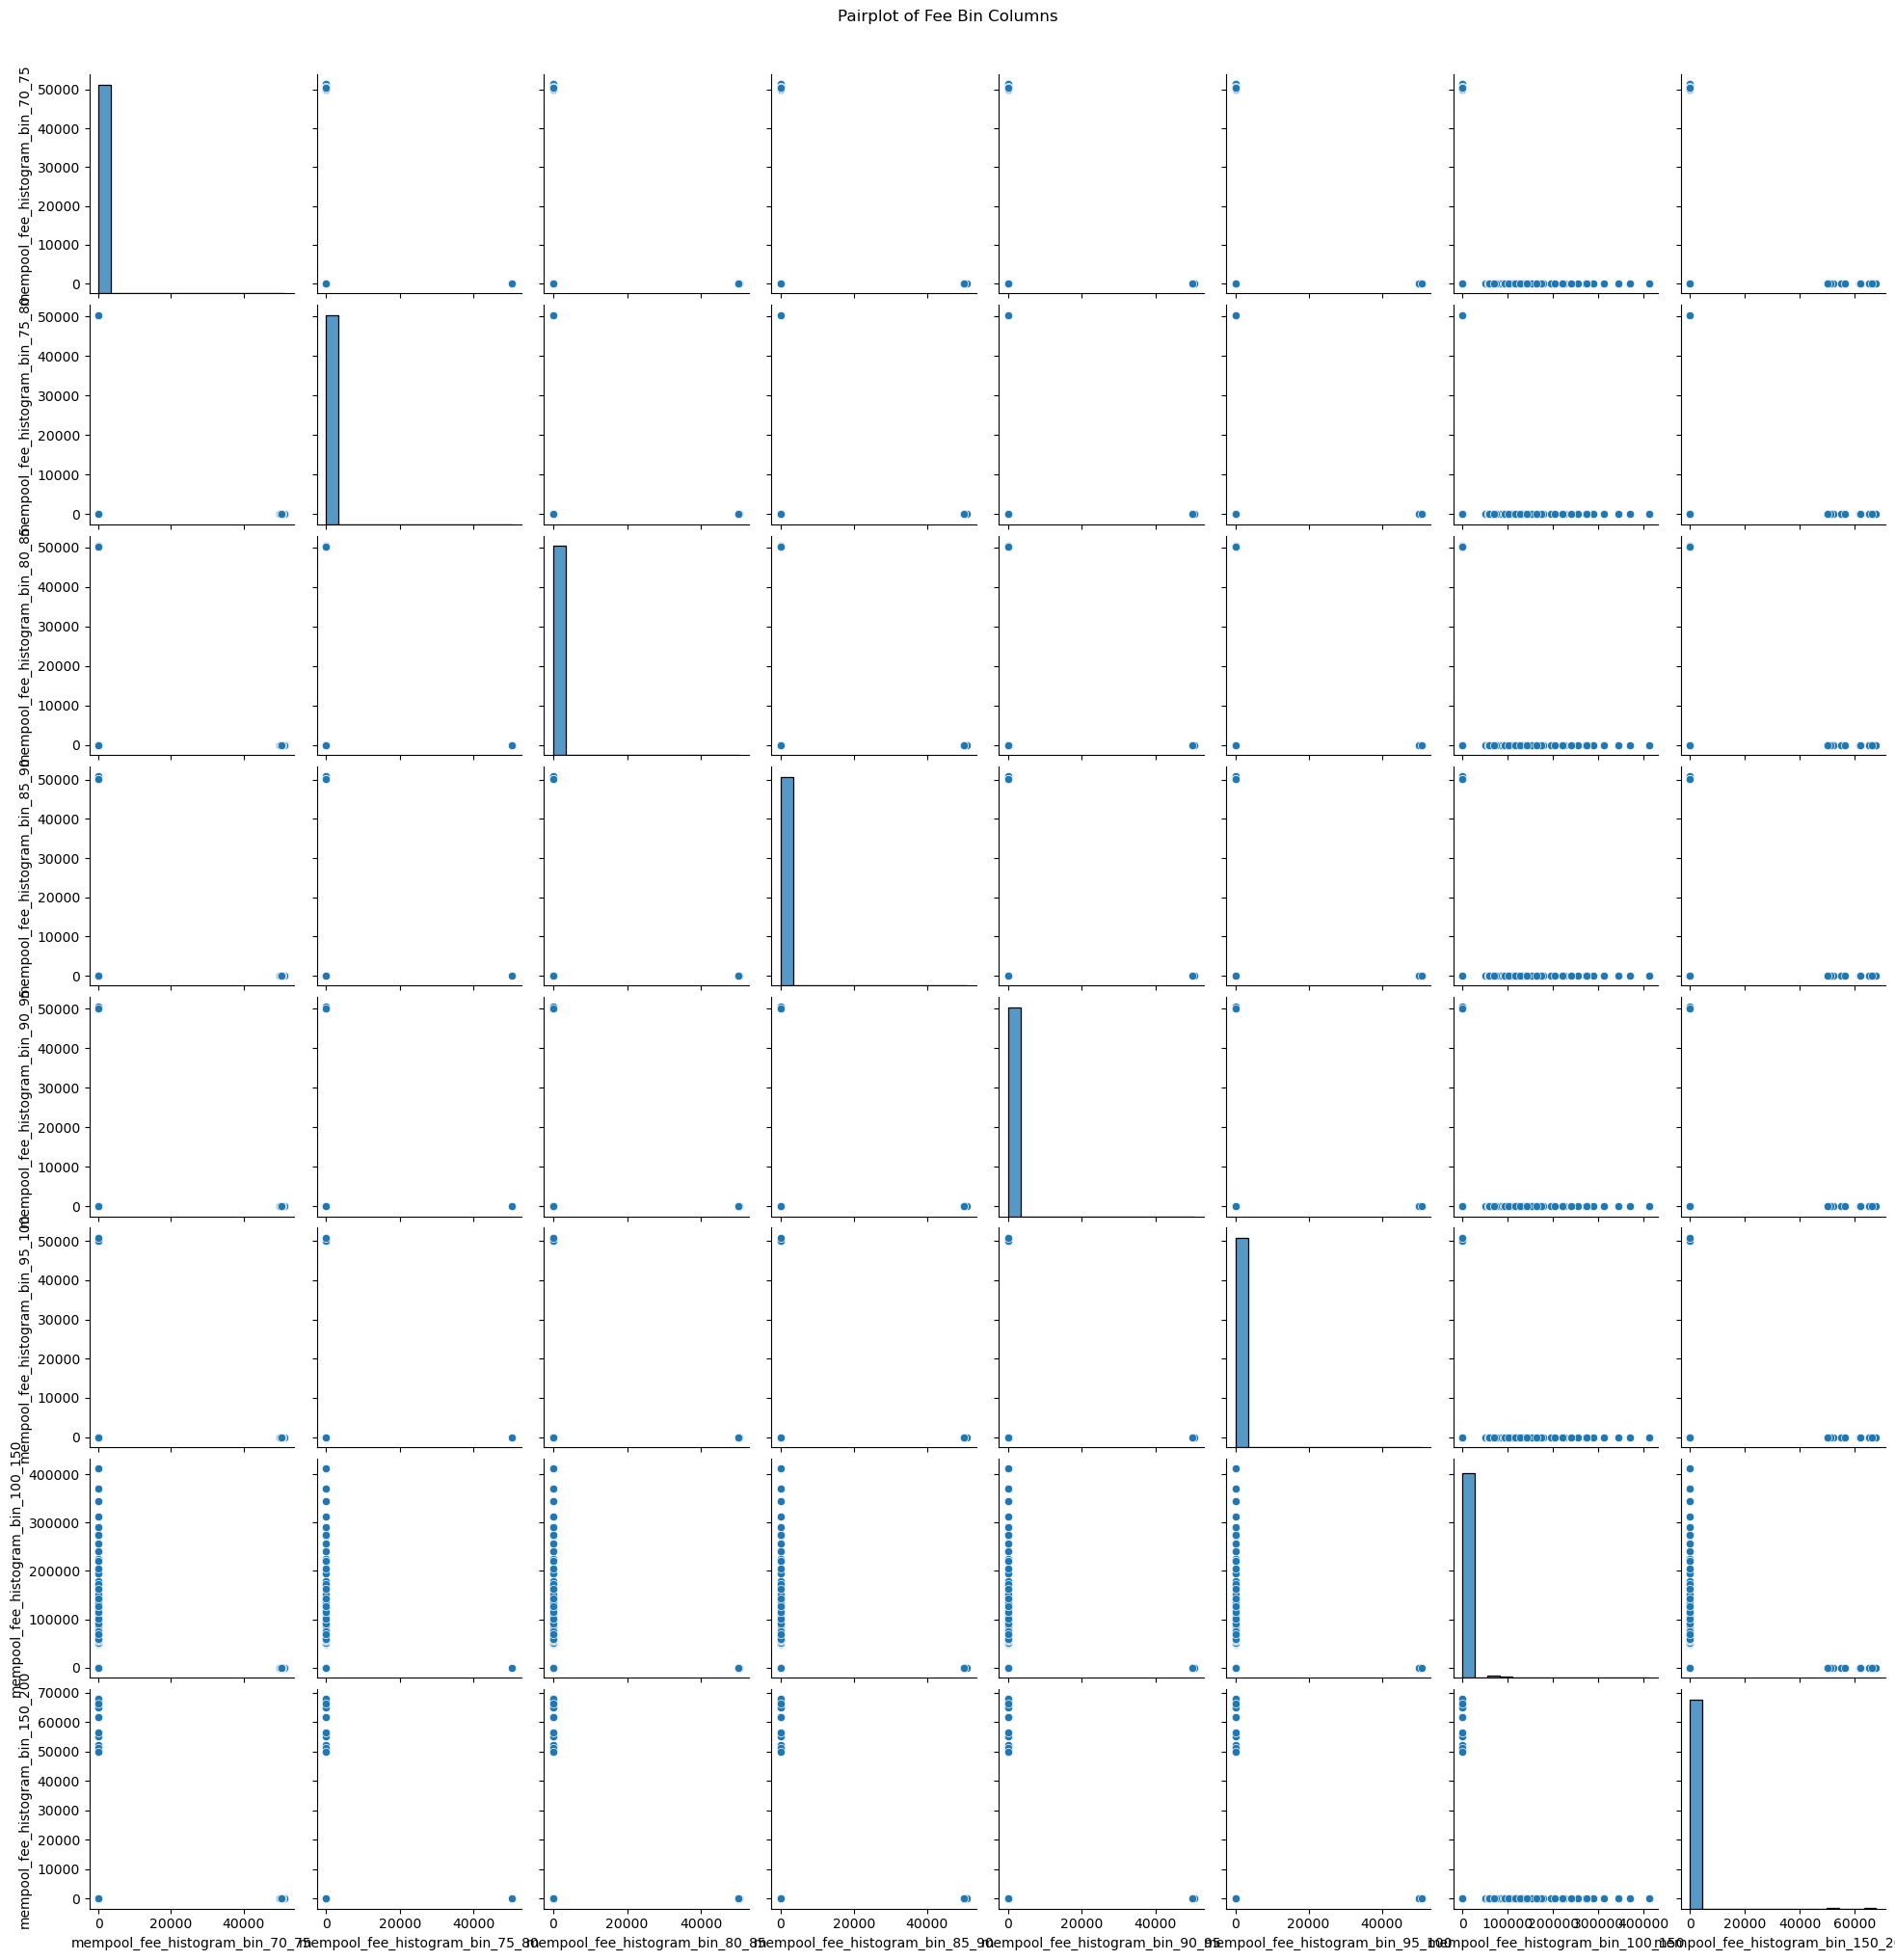

In [11]:
# Visualize distributions of key fee histogram columns (variables of interest))
fee_bin_columns = [
    'mempool_fee_histogram_bin_70_75', 'mempool_fee_histogram_bin_75_80', 'mempool_fee_histogram_bin_80_85',
    'mempool_fee_histogram_bin_85_90', 'mempool_fee_histogram_bin_90_95', 'mempool_fee_histogram_bin_95_100',
    'mempool_fee_histogram_bin_100_150', 'mempool_fee_histogram_bin_150_200',
]

plt.figure(figsize=(12, 8))
for i, col in enumerate(fee_bin_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Fee Bin (satoshis)')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[fee_bin_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Fee Bin Columns')
plt.show()

# Boxplot to identify outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[fee_bin_columns])
plt.title('Boxplot of Fee Bin Columns')
plt.xticks(rotation=45)
plt.show()

# Pairplot to explore relationships between fee columns
sns.pairplot(df[fee_bin_columns])
plt.suptitle('Pairplot of Fee Bin Columns', y=1.02)
plt.show()

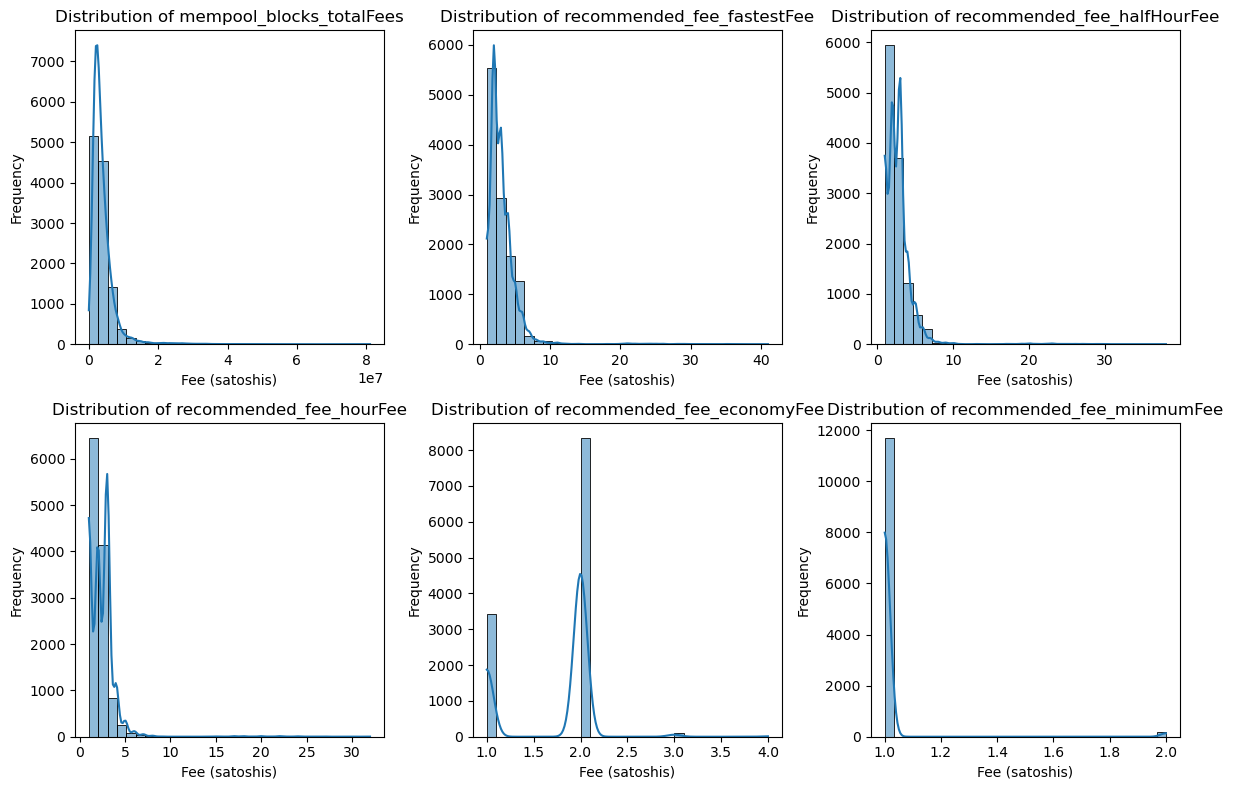

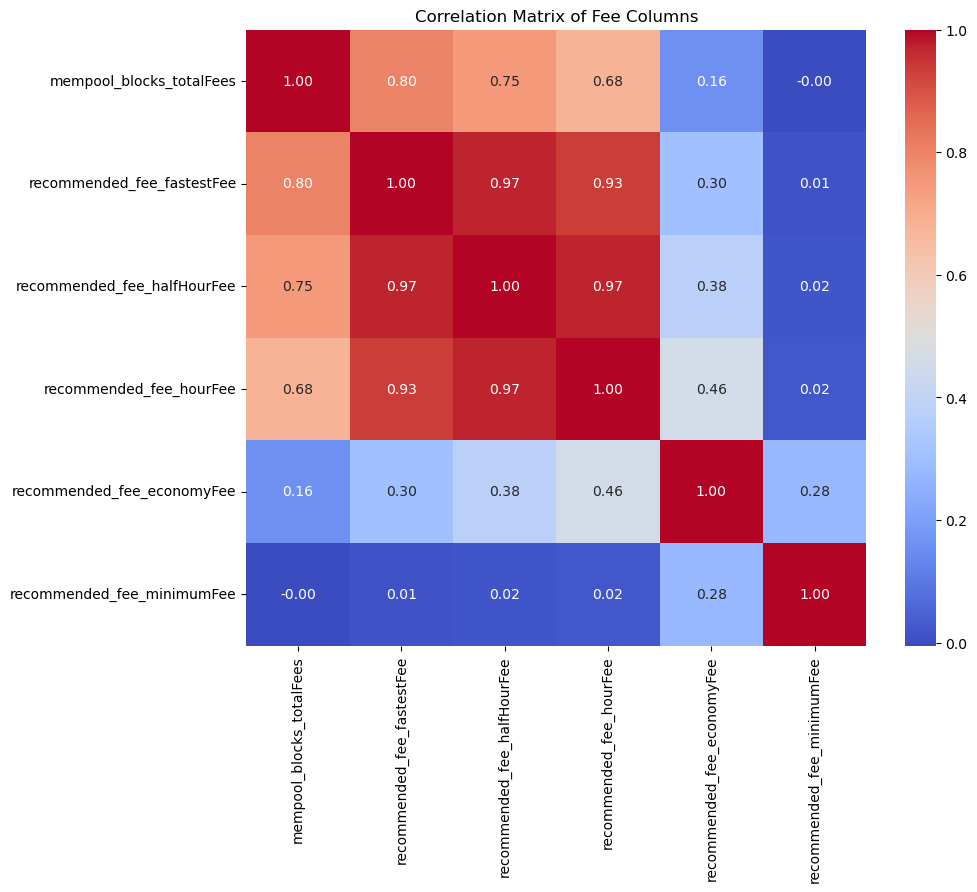

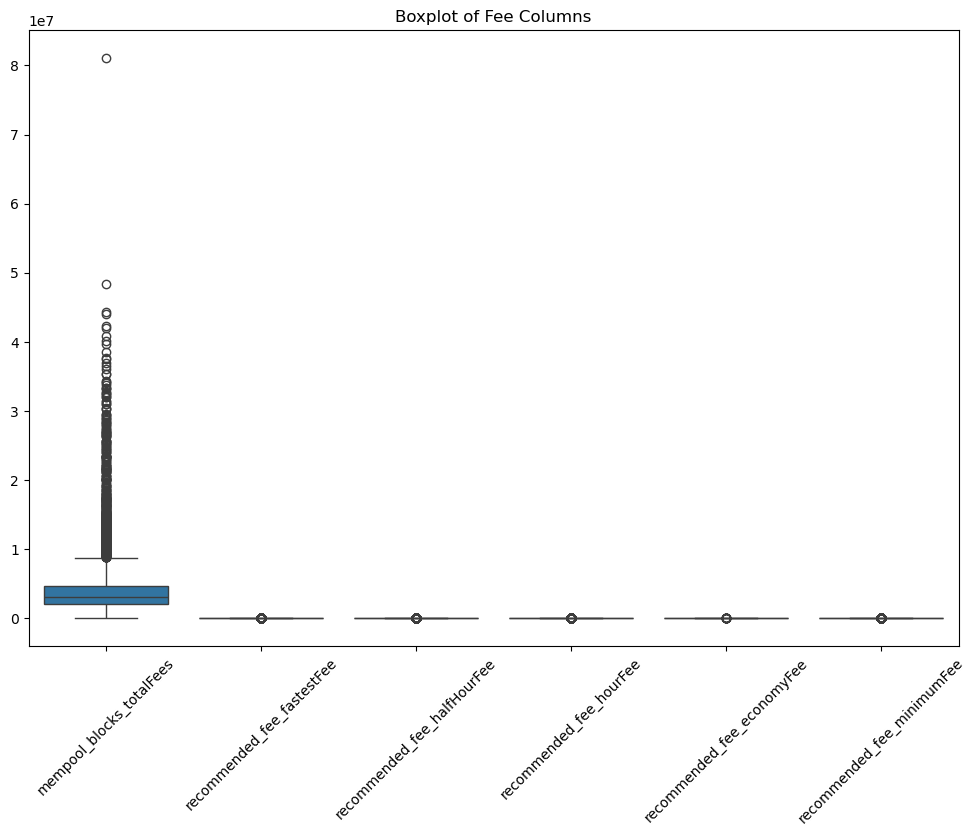

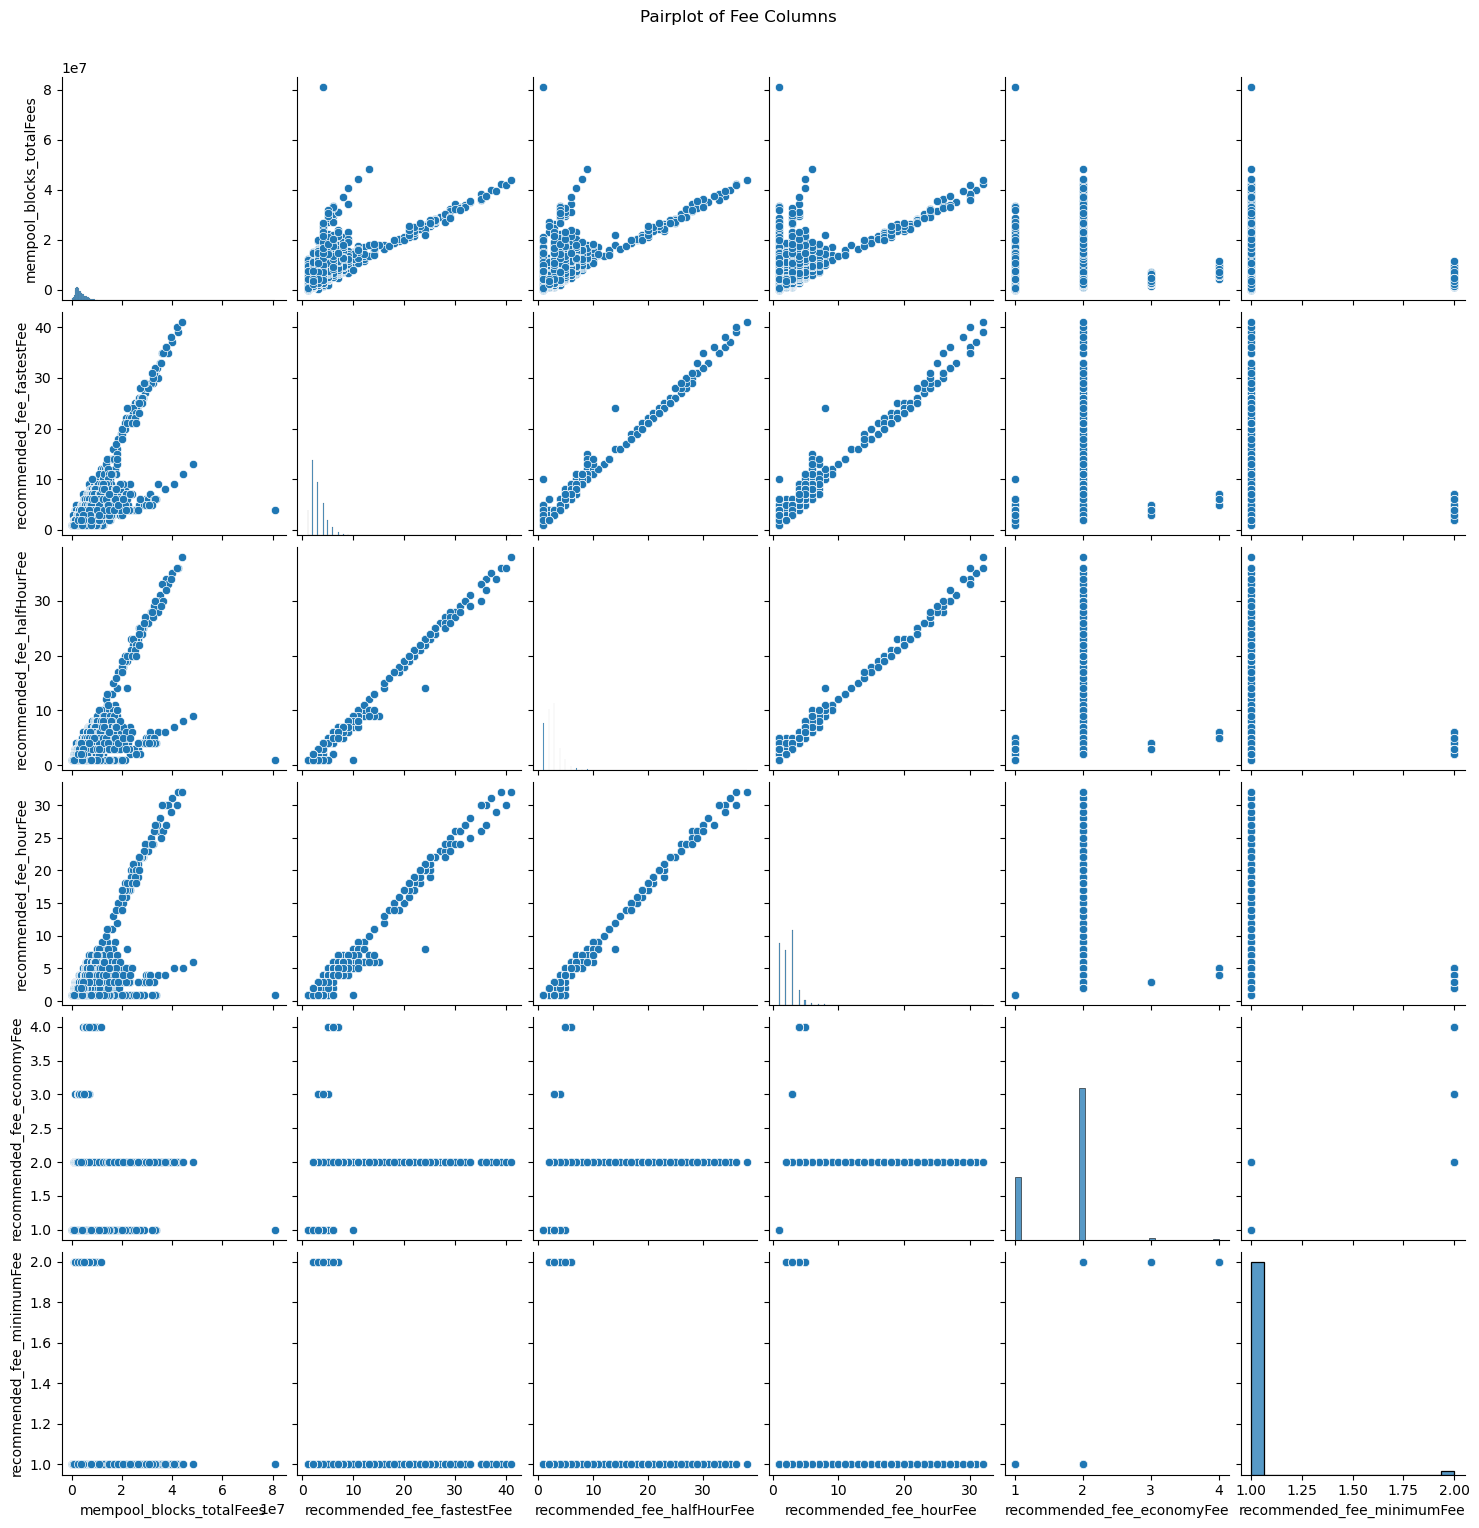

In [12]:
# Visualize distributions of key fee columns (Y response of interest)
fee_columns = [
    'mempool_blocks_totalFees', 'recommended_fee_fastestFee',
    'recommended_fee_halfHourFee', 'recommended_fee_hourFee',
    'recommended_fee_economyFee', 'recommended_fee_minimumFee'
]

plt.figure(figsize=(12, 8))
for i, col in enumerate(fee_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Fee (satoshis)')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[fee_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Fee Columns')
plt.show()

# Boxplot to identify outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[fee_columns])
plt.title('Boxplot of Fee Columns')
plt.xticks(rotation=45)
plt.show()

# Pairplot to explore relationships between fee columns
sns.pairplot(df[fee_columns])
plt.suptitle('Pairplot of Fee Columns', y=1.02)
plt.show()

## Split dataset

The dataset was first sorted chronologically by timestamp to preserve the natural time order of the observations. We then split the data into a training set and a testing set, using the first 80% of the data for training and the remaining 20% for testing. This approach ensures that the training data consists of earlier observations and the testing data consists of later observations, simulating a realistic forecasting scenario. No random shuffling was applied to prevent data leakage across time.

In [13]:
df = df.sort_values('timestamp')

train_size = int(len(df) * 0.8)

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

X_train = train_df.drop(columns=['recommended_fee_fastestFee'])
y_train = train_df['recommended_fee_fastestFee']

X_test = test_df.drop(columns=['recommended_fee_fastestFee'])
y_test = test_df['recommended_fee_fastestFee']

## Parameter Search and Baseline Model Selection

In [14]:
# Log-transform the response variable to stabilize variance and reduce the impact of heavy-tailed distribution
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

### 1. Random Forest

In [ ]:
# Step 1: Define the parameter distribution for random search
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Step 2: Define the base model
rf = RandomForestRegressor(random_state=42)

# Step 3: RandomizedSearchCV
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,               
    cv=3,                      
    scoring='neg_mean_absolute_error', 
    random_state=42,
    n_jobs=-1                   
)

# Step 4: Fit the model on (X_train, y_train_log)
rf_search.fit(X_train, y_train_log)

# Step 5: Print the best parameters
print("Best Parameters:", rf_search.best_params_)

# Step 6: Retrain the model with the best parameters
best_rf = rf_search.best_estimator_
best_rf.fit(X_train, y_train_log)

# Step 7: Predict (in log space)
y_pred_log = best_rf.predict(X_test)

# Step 8: Inverse the log1p transform
y_pred = np.expm1(y_pred_log)

# Step 9: Evaluate MAE and RMSE
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Step 10: Evaluate R-squared
print("Random Forest R-squared:", r2_score(y_test, y_pred))

The Random Forest model achieved a MAE of 0.0604, RMSE of 0.2338, and an R-squared of 0.9743 on the test set. The low MAE and RMSE suggest that most predictions are close to the true fee values, while the high R-squared indicates that the model explains over 97% of the variance in transaction fees, demonstrating strong predictive performance.

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Fee")
plt.ylabel("Predicted Fee")
plt.title("Random Forest: True vs Predicted")
plt.show()

### 2. Linear Regression

In [ ]:
# Fill missing values in features using mean imputation
imputer = SimpleImputer(strategy='mean')
X_train_filled = imputer.fit_transform(X_train)
X_test_filled = imputer.transform(X_test)

# Step 1: build model
lr = LinearRegression()

# Step 2: train model
lr.fit(X_train_filled, y_train_log)

# Step 3: Predict (in log space)
y_pred_log = lr.predict(X_test_filled)

# Step 4: Inverse the log1p transform
y_pred = np.expm1(y_pred_log)

# Step 5: Calculate MAE and RMSE
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Step 6: Calculate R-squared
print("Linear Regression R-squared:", r2_score(y_test, y_pred))

The Linear Regression model achieved a MAE of 0.4368, RMSE of 1.1015, and an R-squared of 0.4292 on the test set.
The relatively high MAE and RMSE suggest that the model struggles to make accurate predictions. The R-squared value of 0.4292 indicates that the model explains only about 43% of the variance in transaction fees, confirming that Linear Regression is not sufficient to capture the complex patterns in the data.